In [1]:
#Get data ready
import sklearn


In [2]:
from sklearn.datasets import make_circles
n_samples=1000
X,y=make_circles(n_samples,noise=0.03,random_state=42)


In [3]:
len(X)

1000

In [4]:
X[:5],y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]), array([1, 1, 1, 1, 0]))

In [5]:
X.shape

(1000, 2)

In [6]:
#2 features of per sample of X
#Make a dataframe to better represent the data
import pandas as pd
circles=pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"label":y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


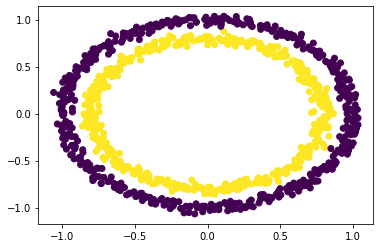

In [7]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c=y)

In [8]:
#convert data to tensors
import torch
import torch.nn as nn
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)


In [9]:
#split data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [10]:
device="cuda" if torch.cuda.is_available() else "cpu"


In [11]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=5)
    self.layer_2=nn.Linear(in_features=5,out_features=1)#binary classification, hence out_features here = 1
  def forward(self,x):
    return self.layer_2(self.layer_1(x))
  
model_0=CircleModelV0().to(device)

In [12]:
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
device

'cuda'

In [14]:
#use nn.Sequential
model_0=nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(5,1)
).to(device)


In [15]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[ 0.0931,  0.2072],
                      [-0.5975,  0.4700],
                      [-0.0065, -0.2601],
                      [-0.4171, -0.6751],
                      [ 0.2913, -0.1842]], device='cuda:0')),
             ('0.bias',
              tensor([0.2605, 0.1342, 0.4761, 0.5177, 0.5750], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0724,  0.1085,  0.0750,  0.0697, -0.4267]], device='cuda:0')),
             ('1.bias', tensor([-0.3068], device='cuda:0'))])

In [16]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [17]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[ 0.0931,  0.2072],
                      [-0.5975,  0.4700],
                      [-0.0065, -0.2601],
                      [-0.4171, -0.6751],
                      [ 0.2913, -0.1842]], device='cuda:0')),
             ('0.bias',
              tensor([0.2605, 0.1342, 0.4761, 0.5177, 0.5750], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0724,  0.1085,  0.0750,  0.0697, -0.4267]], device='cuda:0')),
             ('1.bias', tensor([-0.3068], device='cuda:0'))])

In [18]:
def accuracy(y_true,y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()
  return (correct/len(y_pred))*100

In [19]:
y_logits=model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.3141],
        [-0.3753],
        [-0.3225],
        [-0.3111],
        [-0.5902]], device='cuda:0', grad_fn=<SliceBackward0>)

In [20]:
y_pred_probs=torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4221],
        [0.4073],
        [0.4201],
        [0.4229],
        [0.3566]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [21]:
X_train,y_train,X_test,y_test=X_train.to(device),y_train.to(device),X_test.to(device),y_test.to(device)
epochs=100
for epoch in range(epochs):
  model_0.train()

  y_logits=model_0(X_train).squeeze()
  y_preds=torch.round(torch.sigmoid(y_logits))#logits -> pred probs -> pred labels
  loss=loss_fn(y_logits,y_train)#loss_fn = BCEWithLogitsLoss expects Logits as input, BCELoss expects pred probas as input
  acc=accuracy(y_true=y_train,y_pred=y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits=model_0(X_test).squeeze()
    test_preds=torch.round(torch.sigmoid(test_logits))
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy(y_true=y_test,y_pred=test_preds)
  if epoch%10==0:
    print(f"Epoch : {epoch}|Loss : {loss}|Train Accuracy : {acc}|Test Loss : {test_loss}|Test Accuracy : {test_acc}")


Epoch : 0|Loss : 0.7206061482429504|Train Accuracy : 50.0|Test Loss : 0.7166483998298645|Test Accuracy : 50.0
Epoch : 10|Loss : 0.704321563243866|Train Accuracy : 50.0|Test Loss : 0.7015116810798645|Test Accuracy : 50.0
Epoch : 20|Loss : 0.6985947489738464|Train Accuracy : 40.5|Test Loss : 0.6960442662239075|Test Accuracy : 45.0
Epoch : 30|Loss : 0.6964313983917236|Train Accuracy : 47.125|Test Loss : 0.6939785480499268|Test Accuracy : 49.5
Epoch : 40|Loss : 0.6954967379570007|Train Accuracy : 48.125|Test Loss : 0.6931576132774353|Test Accuracy : 49.5
Epoch : 50|Loss : 0.6950039267539978|Train Accuracy : 48.75|Test Loss : 0.6928184628486633|Test Accuracy : 49.0
Epoch : 60|Loss : 0.6946848630905151|Train Accuracy : 48.625|Test Loss : 0.6926809549331665|Test Accuracy : 49.0
Epoch : 70|Loss : 0.6944455504417419|Train Accuracy : 49.125|Test Loss : 0.6926367282867432|Test Accuracy : 49.5
Epoch : 80|Loss : 0.694251298904419|Train Accuracy : 49.75|Test Loss : 0.6926400065422058|Test Accuracy :

In [22]:
model_0(X_train.to(device))[0].squeeze()

tensor(-0.0823, device='cuda:0', grad_fn=<SqueezeBackward0>)

In [23]:
import requests
from pathlib import Path
#Download helperfunctions from learn pytorch repo if not already downloaded
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("downloading helper_functions.py")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)
from helper_functions import plot_predictions,plot_decision_boundary

downloading helper_functions.py


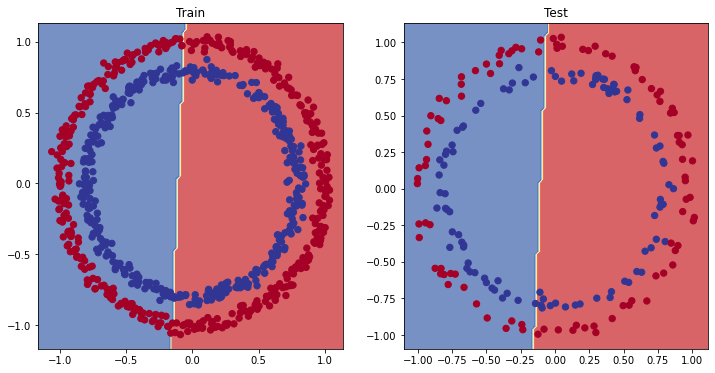

In [24]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

#Improving the model


In [25]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(2,10)
    self.layer_2=nn.Linear(10,10)
    self.layer_3=nn.Linear(10,1)

  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

    

In [26]:
model_1=CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [27]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model_1.parameters(),lr=0.1)


In [28]:
torch.manual_seed(42)

#train for longer
epochs=1000

X_train,y_train,X_test,y_test=X_train.to(device),y_train.to(device),X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  y_logits=model_1(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  loss=loss_fn(y_logits,y_train)
  acc=accuracy(y_true=y_train,y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits=model_1(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy(y_true=y_test,y_pred=test_pred)

  if epoch%10==0:
    print(f"Epoch : {epoch}|Loss : {loss}|Train Accuracy : {acc}|Test Loss : {test_loss}|Test Accuracy : {test_acc}")


Epoch : 0|Loss : 0.7040868997573853|Train Accuracy : 50.125|Test Loss : 0.6922206878662109|Test Accuracy : 54.50000000000001
Epoch : 10|Loss : 0.699105441570282|Train Accuracy : 48.875|Test Loss : 0.6908289194107056|Test Accuracy : 54.50000000000001
Epoch : 20|Loss : 0.6969755291938782|Train Accuracy : 48.25|Test Loss : 0.6907677054405212|Test Accuracy : 53.0
Epoch : 30|Loss : 0.6958053708076477|Train Accuracy : 48.125|Test Loss : 0.6909965872764587|Test Accuracy : 54.0
Epoch : 40|Loss : 0.6950593590736389|Train Accuracy : 48.25|Test Loss : 0.691289484500885|Test Accuracy : 51.5
Epoch : 50|Loss : 0.694545567035675|Train Accuracy : 48.5|Test Loss : 0.6915925741195679|Test Accuracy : 51.5
Epoch : 60|Loss : 0.6941779851913452|Train Accuracy : 48.375|Test Loss : 0.6918899416923523|Test Accuracy : 51.0
Epoch : 70|Loss : 0.6939094662666321|Train Accuracy : 48.25|Test Loss : 0.6921747922897339|Test Accuracy : 50.0
Epoch : 80|Loss : 0.6937107443809509|Train Accuracy : 48.625|Test Loss : 0.6924

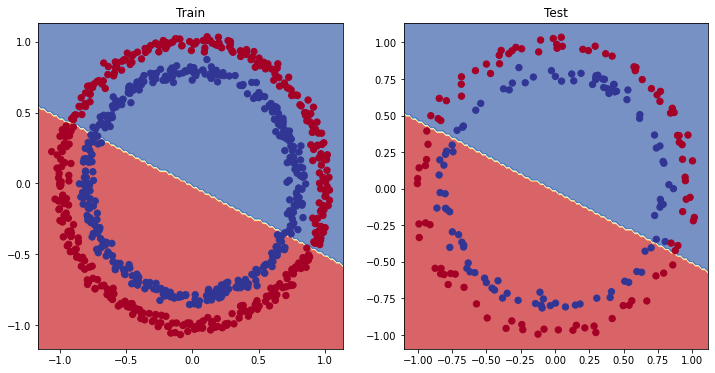

In [29]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

In [30]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(2,128)
    self.layer_2=nn.Linear(128,256)
    self.layer_3=nn.Linear(256,1)
    self.relu=nn.ReLU()

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [31]:
model_2=CircleModelV2().to(device)
model_2.state_dict()


OrderedDict([('layer_1.weight', tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802],
                      [-0.3258, -0.0829],
                      [-0.2872,  0.4691],
                      [-0.5582, -0.3260],
                      [-0.1997, -0.4252],
                      [ 0.0667, -0.6984],
                      [ 0.6386, -0.6007],
                      [ 0.5459,  0.1177],
                      [-0.2296,  0.4370],
                      [ 0.1102,  0.5713],
                      [ 0.0773, -0.2230],
                      [ 0.1900, -0.1918],
                      [ 0.2976,  0.6313],
                      [ 0.4087, -0.3091],
                

In [32]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model_2.parameters(),lr=0.1)


In [33]:
torch.manual_seed(42)
epochs=1000
X_train,y_train,X_test,y_test=X_train.to(device),y_train.to(device),X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_2.train()
  y_logits=model_2(X_train).squeeze()
  y_preds=torch.round(torch.sigmoid(y_logits))#logits->pred probs->pred labels
  loss=loss_fn(y_logits,y_train)
  acc=accuracy(y_true=y_train,y_pred=y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_logits=model_2(X_test).squeeze()
    test_preds=torch.round(torch.sigmoid(test_logits))
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy(y_test,test_preds)
  if epoch%100==0:
    print(f"Epoch : {epoch}|Loss : {loss}|Train Accuracy : {acc}|Test Loss : {test_loss}|Test Accuracy : {test_acc}")


Epoch : 0|Loss : 0.696614682674408|Train Accuracy : 37.625|Test Loss : 0.6951049566268921|Test Accuracy : 43.0
Epoch : 100|Loss : 0.6594203114509583|Train Accuracy : 84.0|Test Loss : 0.6650816202163696|Test Accuracy : 80.0
Epoch : 200|Loss : 0.581163227558136|Train Accuracy : 99.0|Test Loss : 0.5984402894973755|Test Accuracy : 96.0
Epoch : 300|Loss : 0.4078182876110077|Train Accuracy : 99.75|Test Loss : 0.44517767429351807|Test Accuracy : 99.0
Epoch : 400|Loss : 0.4029921591281891|Train Accuracy : 72.875|Test Loss : 0.5191060900688171|Test Accuracy : 62.0
Epoch : 500|Loss : 0.1160828098654747|Train Accuracy : 100.0|Test Loss : 0.15607969462871552|Test Accuracy : 100.0
Epoch : 600|Loss : 0.06854043900966644|Train Accuracy : 100.0|Test Loss : 0.10135103017091751|Test Accuracy : 100.0
Epoch : 700|Loss : 0.046073030680418015|Train Accuracy : 100.0|Test Loss : 0.07389145344495773|Test Accuracy : 100.0
Epoch : 800|Loss : 0.03380456194281578|Train Accuracy : 100.0|Test Loss : 0.05803442001342

In [34]:
model_2.eval()
with torch.inference_mode():
  y_preds=torch.round(torch.sigmoid(model_2(X_test))).squeeze()




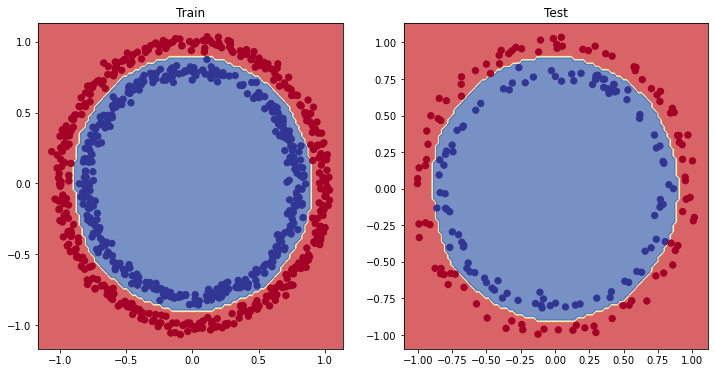

In [35]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2,X_test,y_test)

# Multiclass Classification

In [50]:
from sklearn.datasets import make_blobs
NUM_CLASSES=4
NUM_FEATURES=2
RANDOM_SEED=42

X_blob,y_blob=make_blobs(n_samples=1000,n_features=NUM_FEATURES,centers=NUM_CLASSES,cluster_std=1.5,random_state=RANDOM_SEED)
X_blob=torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.long)

X_blob_train,X_blob_test,y_blob_train,y_blob_test=train_test_split(X_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED)
X_blob.shape,y_blob.shape

(torch.Size([1000, 2]), torch.Size([1000]))

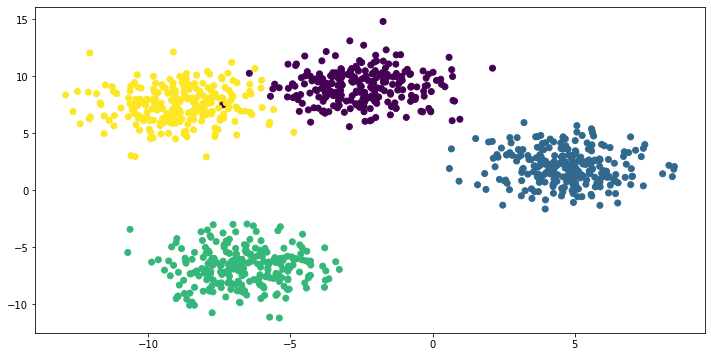

In [51]:
plt.figure(figsize=(12,6))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob)

In [52]:
class BlobModel(nn.Module):
  def __init__(self,in_features,out_features,hidden_units=8):
    super().__init__()
    self.linear_layer_stack=nn.Sequential(
        nn.Linear(in_features,hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units,hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units,out_features)

    )
  def forward(self,x):
    return self.linear_layer_stack(x)


model_3=BlobModel(2,4).to(device)
model_3.state_dict()

OrderedDict([('linear_layer_stack.0.weight', tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]], device='cuda:0')),
             ('linear_layer_stack.0.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691],
                     device='cuda:0')),
             ('linear_layer_stack.2.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
                      [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115],
                      [ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044, -0.1546,  0.2041,  0.0633],
                      [ 0.1795, -0.2155, -0.3500, -0.1366, -0.2712,  0.2901,  0.1018,  0.1464],
      

In [53]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model_3.parameters(),lr=0.1)


In [54]:
model_3.eval()
with torch.inference_mode():
  y_logits=model_3(X_blob_test.to(device))
y_logits[:5]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')

In [55]:
y_blob_test[:5]

tensor([1, 3, 2, 1, 0])

In [56]:
y_pred_probs=torch.softmax(y_logits,dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [57]:
y_preds=torch.argmax(y_pred_probs)
y_preds==y_blob_test.to(device)

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

#Train the model

In [58]:
X_blob_train,X_blob_test,y_blob_train,y_blob_test=X_blob_train.to(device),X_blob_test.to(device),y_blob_train.to(device),y_blob_test.to(device)

In [59]:
y_blob_train.dtype

torch.int64

In [60]:
torch.manual_seed(42)
epochs=100

for epoch in range(epochs):
  model_3.train()

  y_logits=model_3(X_blob_train).squeeze()
  y_preds=torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss=loss_fn(y_logits,y_blob_train)
  acc=accuracy(y_blob_train,y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits=model_3(X_blob_test).squeeze()
    test_preds=torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss=loss_fn(test_logits,y_blob_test)
    test_acc=accuracy(y_blob_test,test_preds)

  if epoch%10==0:
    print(f"Epoch : {epoch}|Loss : {loss}|Train Accuracy : {acc}|Test Loss : {test_loss}|Test Accuracy : {test_acc}")



Epoch : 0|Loss : 1.1588265895843506|Train Accuracy : 40.375|Test Loss : 1.0755419731140137|Test Accuracy : 48.0
Epoch : 10|Loss : 0.6447554230690002|Train Accuracy : 96.75|Test Loss : 0.6606872081756592|Test Accuracy : 97.5
Epoch : 20|Loss : 0.42535150051116943|Train Accuracy : 98.5|Test Loss : 0.43074119091033936|Test Accuracy : 100.0
Epoch : 30|Loss : 0.2529423236846924|Train Accuracy : 99.125|Test Loss : 0.24507619440555573|Test Accuracy : 99.5
Epoch : 40|Loss : 0.11232151091098785|Train Accuracy : 99.25|Test Loss : 0.10228516906499863|Test Accuracy : 99.5
Epoch : 50|Loss : 0.06626511365175247|Train Accuracy : 99.25|Test Loss : 0.058475375175476074|Test Accuracy : 99.5
Epoch : 60|Loss : 0.05068015679717064|Train Accuracy : 99.25|Test Loss : 0.042932283133268356|Test Accuracy : 99.5
Epoch : 70|Loss : 0.042996764183044434|Train Accuracy : 99.25|Test Loss : 0.03490966185927391|Test Accuracy : 99.5
Epoch : 80|Loss : 0.038361385464668274|Train Accuracy : 99.25|Test Loss : 0.0298782251775

In [63]:
test_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [62]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 13.8 MB/s 


In [66]:
from torchmetrics import Accuracy
torchmetric_accuracy=Accuracy(task="multiclass", num_classes=4).to(device)
torchmetric_accuracy(test_preds,y_blob_test)

tensor(0.9950, device='cuda:0')